# Implementation

- We will implement an ensemble method(specifically AdaBoost) on the Titanic survival data. I want to see if this can perform better than either the perceptron or the random forest method(which also happens to be an ensemble method)


# 1 - Importing necessary libraries and dataset

- we will use the same Titanic data as was used for Perceptron

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("../../data/Titanic-Dataset.csv")

# 2 - Initial screening and data clensing

- we will look for missing values in the dataset and drop any columns with significant numbers of missing values

In [2]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

** Remarks **

- Looks like there are a lot of missing values in Cabin, Age, and 2 in Embarked. Since AdaBoost is sensititve to null values we'll drop the respective columns.

- We will also drop Name, Passenger ID, and Ticket as its irrelevant to our survival analysis

In [4]:
# Drop Cabin (too many missing), Name and Ticket (not immediately useful)
titanic_cleaned = df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])   

# Also drop rows with missing values in the remaining columns
titanic_cleaned = titanic_cleaned.dropna()

# Double-check the cleaned DataFrame
print(titanic_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB
None


# 2 - Initial visualization

/var/folders/y5/q7gh66fx2t58smbbcwxps5h40000gn/T/ipykernel_7015/3198714534.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Survived", palette="pastel", legend=False)


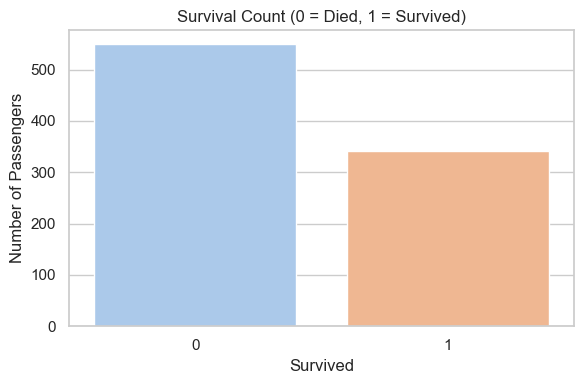

/var/folders/y5/q7gh66fx2t58smbbcwxps5h40000gn/T/ipykernel_7015/3198714534.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Survived", loc="upper right")


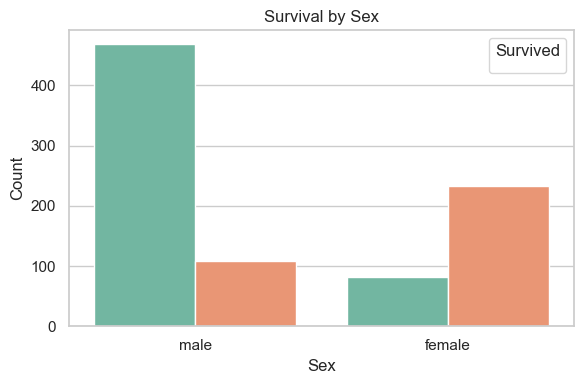

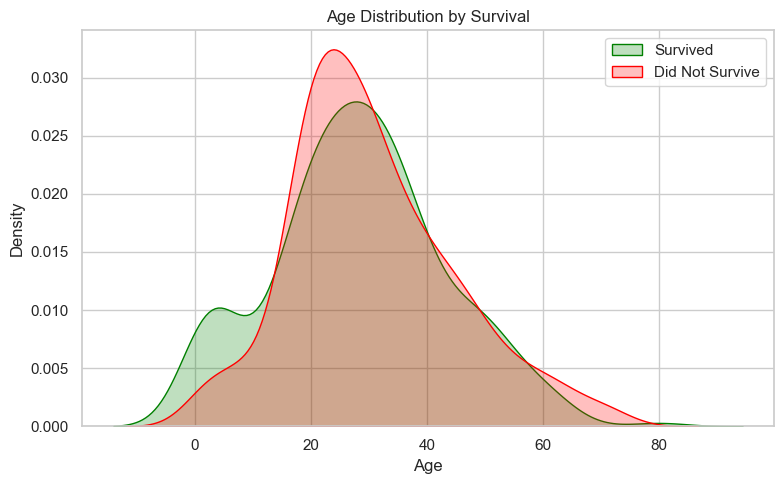

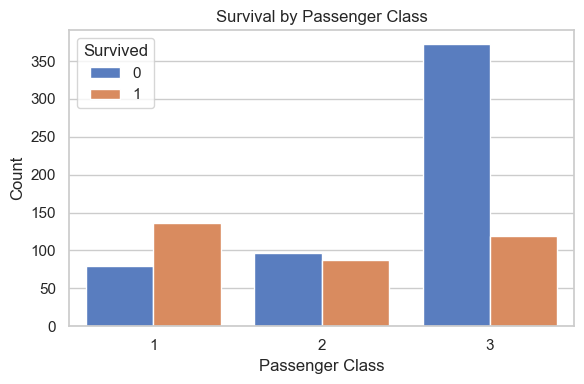

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plot 1: Survival Count
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Survived", palette="pastel", legend=False)
plt.title("Survival Count (0 = Died, 1 = Survived)")
plt.xlabel("Survived")
plt.ylabel("Number of Passengers")
plt.tight_layout()
plt.show()

# Plot 2: Survival by Sex
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Sex", hue="Survived", palette="Set2",legend=False)
plt.title("Survival by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", loc="upper right")
plt.tight_layout()
plt.show()

# Plot 3: Age Distribution by Survival
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df[df["Survived"] == 1], x="Age", label="Survived", fill=True, color="green")
sns.kdeplot(data=df[df["Survived"] == 0], x="Age", label="Did Not Survive", fill=True, color="red")
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Class vs Survival
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Pclass", hue="Survived", palette="muted")
plt.title("Survival by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived")
plt.tight_layout()
plt.show()


** Remarks **

- We already know what to expect here, already seen this with other methods. Only thing to note is that by using an ensemble method, we're not required to drop any attributes that doesn't have clear distinction, so we can proceed with all the above attributes.

# 3 - One-hot encode catagorical variables & split variable

- we will use one-hot encoding to convert the catagorical variables such as sex and fareclass

- we split the dataset into training and test

- with pre processing done, we will move on to implementing the model

In [5]:
titanic_encoded = pd.get_dummies(titanic_cleaned, drop_first=True)

In [7]:
X = titanic_encoded.drop(columns='Survived')
y = titanic_encoded['Survived']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# 4 - Train AdaBoost model with decision tree as stump

In [10]:
# Use decision stumps as weak learners
base_learner = DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(base_learner, n_estimators=50, learning_rate=1.0, random_state=42)

ada_model.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

# 5 - Print classification report, confusion matrix

- we will evaluate the performance of this model by looking at its metrics and comparing it to previous models

In [11]:
y_pred = ada_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       127
           1       0.74      0.77      0.75        87

    accuracy                           0.79       214
   macro avg       0.79      0.79      0.79       214
weighted avg       0.80      0.79      0.80       214



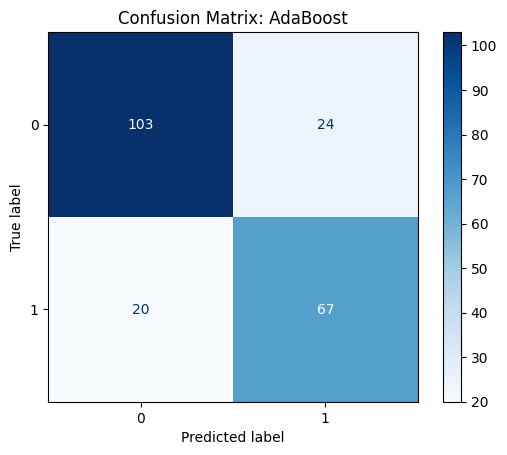

In [13]:
ConfusionMatrixDisplay.from_estimator(ada_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix: AdaBoost")
plt.grid(False)
plt.show()

** Remarks **
Here’s a concise, critical comparison of **AdaBoost** and **Random Forest** on the Titanic dataset based on your classification reports:


## Model Comparison: AdaBoost vs. Random Forest

### **Performance Summary**

| Metric        | AdaBoost | Random Forest |
| ------------- | -------- | ------------- |
| Accuracy      | 0.79     | 0.78          |
| Precision (0) | 0.84     | 0.79          |
| Recall (0)    | 0.81     | 0.83          |
| F1-score (0)  | 0.82     | 0.81          |
| Precision (1) | 0.74     | 0.76          |
| Recall (1)    | 0.77     | 0.71          |
| F1-score (1)  | 0.75     | 0.73          |
| Macro Avg F1  | 0.79     | 0.77          |

- AdaBoost slightly outperformed Random Forest in overall accuracy (79% vs 78%) and macro-averaged metrics, and had higher recall on the positive class (survivors) — 77% vs 71% — which is valuable when false negatives (missing survivors) are costly.

- Precision for the non-survivor class (0) was also better with AdaBoost, showing stronger discriminatory power.


- We also note that both models showed some trade-off between precision and recall, typical of unbalanced or complex classification tasks.



# 6 - Plot feature importance

- We will plot the importance of each feature as calculated in AdaBoost, and see if it differed from the ones in Random Forest

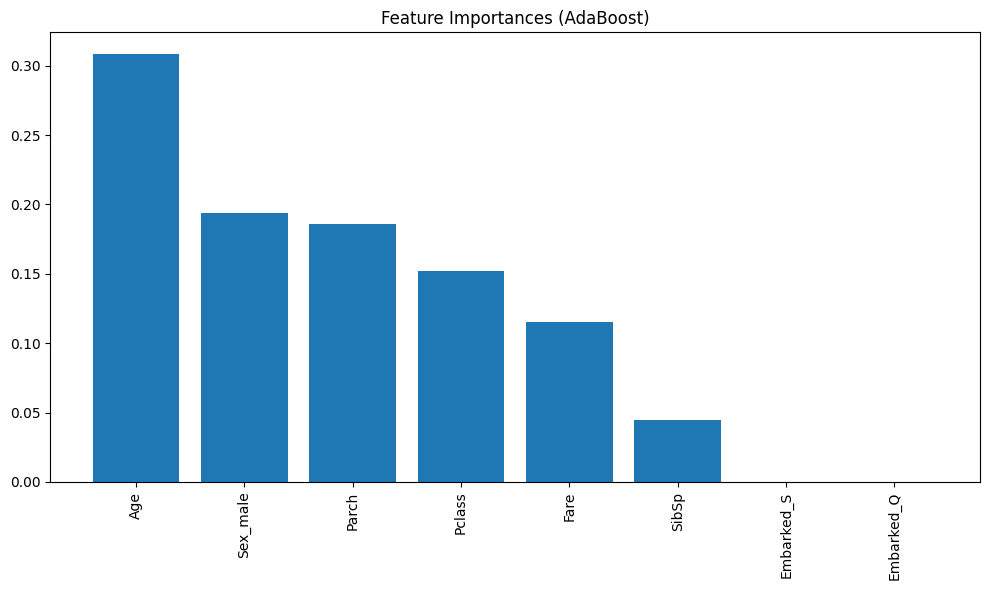

In [ ]:
importances = ada_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Feature Importances (AdaBoost)")
plt.tight_layout()
plt.show()


** Remarks **


- The top feature continues to be age, far higher than the second place with a importance score of 0.3+. Compare to age, Sex and Fare both saw a decrease in their importance score both in magnitude and relative to Age. This shows some fundamental difference in these two models and how they weight different attributes.

# 7 Comparison with Gradient Boosting

- Out of curiousity, I will also quickly implement Gradient Boosting just to see if it performs any better

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       127
           1       0.79      0.67      0.72        87

    accuracy                           0.79       214
   macro avg       0.79      0.77      0.78       214
weighted avg       0.79      0.79      0.79       214

Accuracy: 0.79


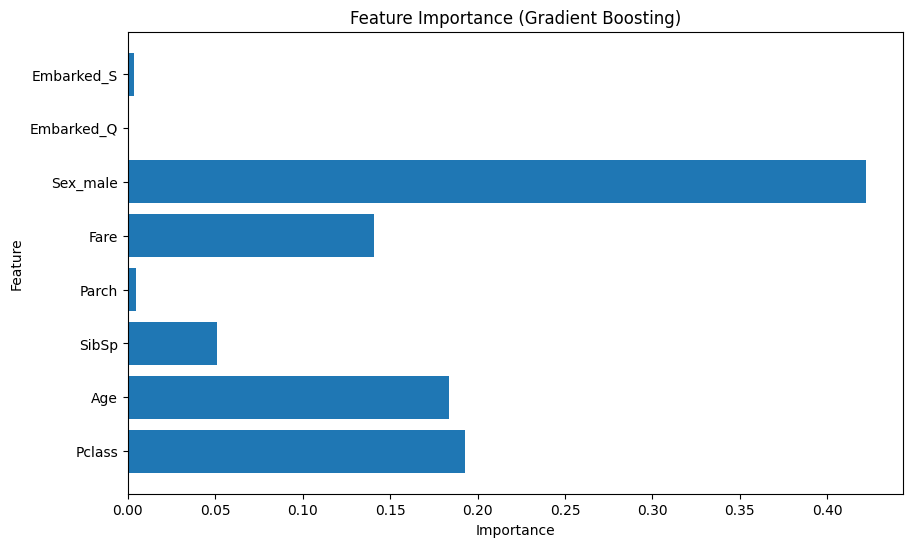

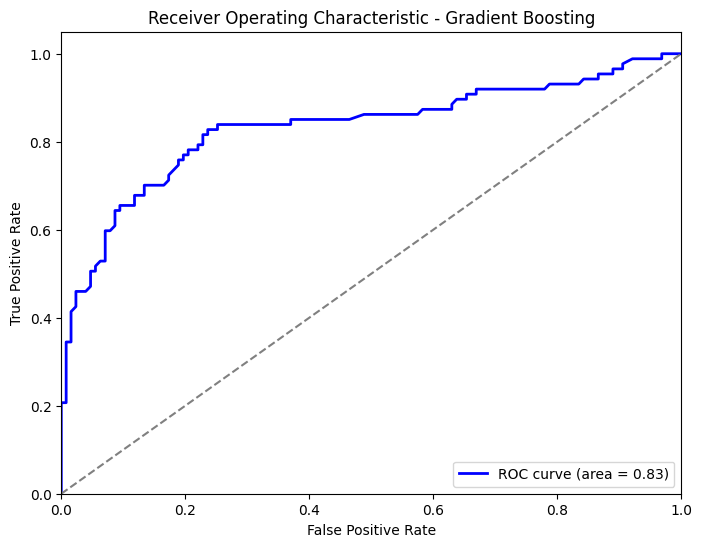

In [15]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Instantiate and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Print Classification Report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Accuracy
accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy:.2f}")


# Ensure we are using the correct feature names for plotting
# Drop the target column from the feature names
feature_names = X_train.columns  # assuming X_train is a DataFrame

# Visualize Feature Importances
feature_importances = gb_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


** Remarks **

- Accuracy: 0.79

- Precision/Recall:

    - Class 0: precision = 0.79, recall = 0.88

    - Class 1: precision = 0.79, recall = 0.67

- We can see Gradient Boosting matched AdaBoost in accuracy but was more polarized, excellent at identifying non-survivors (high recall) but worse than both AdaBoost and Random Forest at identifying survivors (lower recall). This suggests it may be overfitting on the majority class. Gradient Boosting is more powerful and flexible than AdaBoost, but also more sensitive to hyperparameters and prone to overfitting without tuning.

# Conclusion

- Through implementing two additional ensemble methods on the Titanic dataset, we still only ahcieved around 80% accuracy in predicting survival. Regardless, it was very interesting seeing how the different ensemble methods like AdaBoosting, Gradient Boosting, and Random forest each had different accuracy and consistentcy as a result of the algorithum they use

- I'm tempted to conclude that the survival dataset is very dificult to truly predict with simple models that we are able to implement, as the dataset naturally contains a lot of unexpectable variations and outliers.